## Raman Challenge: Machine Learning Model for Concentration Prediction

This notebook demonstrates the development of **Partial Least Squares (PLS) regression models** for predicting concentrations of three compounds from Raman spectra:

- **Glucose** (C₆H₁₂O₆)
- **Sodium acetate** (Na_acetate)
- **Magnesium sulfate** (Mg_SO4)

The analysis is performed **one instrument at a time** to account for instrument-specific variations in spectral characteristics. This approach ensures that models are tailored to the unique spectral response and calibration of each instrument, improving prediction accuracy and model reliability.

In [1]:
from pathlib import Path
from typing import Literal
import pandas as pd
import numpy as np
import ramanspy as rp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, root_mean_squared_error

import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

/home/nicolas/PycharmProjects/raman-spectra/.venv/lib/python3.12/site-packages/ramanspy/core.py:26: SyntaxWarning: invalid escape sequence '\ '
  """


In [2]:
# Data directory path
data_path = Path("../data/dig-4-bio-raman-transfer-learning-challenge")

# Fingerprint region
MIN_WAVENUMBER = 300
MAX_WAVENUMBER = 1942

# Standard preprocessing pipeline without normalization
standard_pipeline_without_normalisation = rp.preprocessing.Pipeline([
    rp.preprocessing.misc.Cropper(region=(MIN_WAVENUMBER, MAX_WAVENUMBER)),  # Fingerprint region
    rp.preprocessing.despike.WhitakerHayes(),          # Remove cosmic rays
    rp.preprocessing.denoise.SavGol(window_length=9, polyorder=3),  # Smooth noise
    rp.preprocessing.baseline.ASPLS(),                 # Remove baseline drift
    # rp.preprocessing.normalise.MinMax()  # Excluded for regression tasks
])

# Standard preprocessing pipeline with normalization
standard_pipeline = rp.preprocessing.Pipeline([
    rp.preprocessing.misc.Cropper(region=(MIN_WAVENUMBER, MAX_WAVENUMBER)),
    rp.preprocessing.despike.WhitakerHayes(),
    rp.preprocessing.denoise.SavGol(window_length=9, polyorder=3),
    rp.preprocessing.baseline.ASPLS(),
    rp.preprocessing.normalise.MinMax()
])

In [3]:
"""
Utility functions
"""

def find_spectral_columns(df: pd.DataFrame) -> tuple[list[str], list[str], np.ndarray]:
    """
    Identifies spectral data columns by checking if the column name can be converted to a float.
    This is a robust way to separate metadata from spectral data.
    """
    spectral_cols = []
    metadata_cols = []
    for col in df.columns:
        try:
            float(col)
            spectral_cols.append(col)
        except (ValueError, TypeError):
            metadata_cols.append(col)

    wavenumbers = pd.to_numeric(spectral_cols)
    return metadata_cols, spectral_cols, wavenumbers

### Normalization: A Critical Preprocessing Decision

A fundamental preprocessing decision in quantitative Raman spectroscopy is whether to normalize the spectra. This choice involves an important trade-off:

- **Normalize**: Ensures the model learns from **chemical differences** rather than measurement artifacts (laser power fluctuations, integration time variations, focusing differences, etc.). This helps remove instrumental effects that could confound the analysis.

- **Don't normalize**: Preserves the **relationship between peak height and concentration**, which is essential for quantitative regression. Absolute intensity information can be directly related to analyte concentration in ideal conditions.

**Objective**: Display some random spectra from the dataset to visually assess the intensity variations and determine whether normalization is necessary for this analysis.

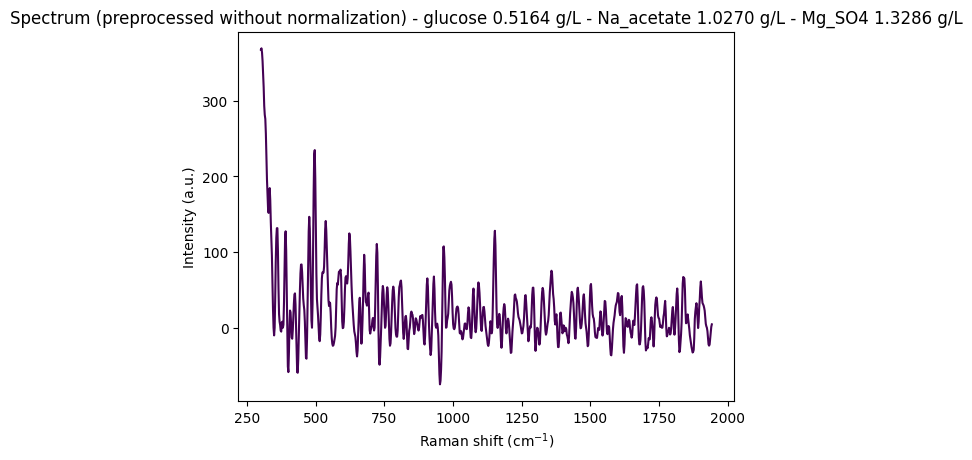

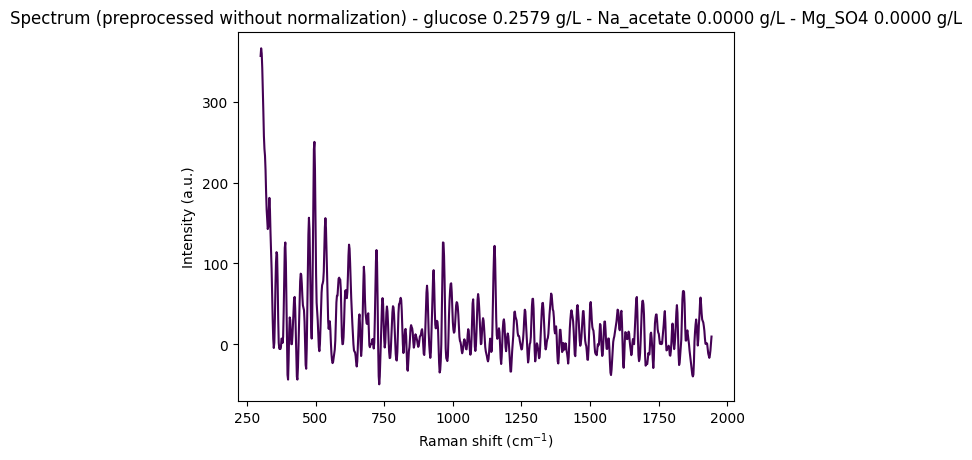

In [4]:
"""
Display some random spectra from the dataset
"""

# Load data from anton_532 instrument
df = pd.read_csv(data_path / "anton_532.csv").drop(columns=["MSM_present", "fold_idx"])

# Separate spectral columns (numeric column names = wavenumbers) from metadata
metadata_cols, spectral_cols, wavenumbers = find_spectral_columns(df)

spectral_container = rp.SpectralContainer(
    spectral_data=df[spectral_cols].values,
    spectral_axis=wavenumbers
)

spectral_container = standard_pipeline_without_normalisation.apply(spectral_container)

# Select 2 random spectra
random_indices = np.random.choice(len(df), size=2, replace=False)

for i in random_indices:
    spectrum = spectral_container[i]
    metadata = df[metadata_cols].iloc[i].to_dict()

    # Create informative title with concentration information
    title = (
        f"Spectrum (preprocessed without normalization) - "
        f"glucose {metadata['glucose']:.4f} g/L - "
        f"Na_acetate {metadata['Na_acetate']:.4f} g/L - "
        f"Mg_SO4 {metadata['Mg_SO4']:.4f} g/L"
    )

    # Plot the spectrum
    rp.plot.spectra(spectra=[spectrum], plot_type="single", title=title)
    rp.plot.show()

### Discussion: Normalization in the Preprocessing Pipeline

We observe that without normalization, spectral intensities can reach very high values (e.g., ~350 arbitrary units), which is problematic for machine learning models that expect scaled data. However, choosing the appropriate normalization method is challenging due to noise and subtle spectral variations that must be preserved for quantitative analysis.

Variations in overall spectral intensity can result from several instrumental factors:

- **Laser power fluctuations**: Changes in laser output power between measurements
- **Focusing/sampling position**: Variations in sample positioning and laser focus
- **Integration time**: Differences in measurement duration
- **Detector response**: Variations in detector sensitivity or calibration

Normalization corrects for these instrumental effects, ensuring that differences between spectra reflect **chemical composition** rather than **measurement artifacts**.

#### Common Normalization Methods

**1. Area Under the Curve (AUC) Scaling**

- **What it does:** Divides each spectrum by its total area, making all spectra have area = 1.
- **Why it's problematic for regression:** Destroys concentration information. Stronger peaks (indicating higher concentration) lead to a larger total area, but AUC scaling erases this difference by forcing all spectra to have the same area.
- **Best for:** Classification tasks (focus on spectral shape, not absolute intensity). **Avoid for regression.**

**2. MinMax Scaling**

- **What it does:** Scales each spectrum so its minimum is 0 and maximum is 1.
- **Problems for regression:**
  - Scaling depends on the highest point, which may be a compound peak, solvent peak, or noise artifact.
  - Inconsistent scaling between samples distorts the linear relationship between peak height and concentration.
  - Different samples may have different scaling factors, making quantitative comparisons difficult.
- **Best for:** Some ML classification tasks. **Use with caution for regression.**

**3. Internal Standard Normalization (Preferred for Quantitative Analysis)**

- **What it is:** Normalize by dividing the analyte peak(s) by a stable reference peak (from a constant component or added internal standard).
- **Why it's best:** Corrects for experimental variations (laser power, integration time, focus, detector response) while preserving the linear relationship needed for regression.
- **Formula:**
  ```
  Normalized Signal = (Analyte Peak Intensity) / (Standard Peak Intensity)
  ```
- **Best for:** Quantitative analysis and regression.

#### Summary Table

| Method                  | What it Does                  | Pro                                         | Con                                         | Best for                        |
|-------------------------|-------------------------------|---------------------------------------------|---------------------------------------------|----------------------------------|
| **AUC Scaling**         | Area = 1 for all spectra      | Focuses on shape                            | **Destroys intensity info**                 | Classification                   |
| **MinMax Scaling**      | Scales to [0, 1]              | Preserves relative peak heights             | Inconsistent; distorts quantitative info    | Some classification              |
| **Internal Standard**   | Ratio to stable peak          | **Corrects for variations; preserves linearity** | Requires suitable standard/peak         | **Regression, quantitative**      |

#### Decision

Unfortunately, internal standard normalization is difficult to implement in this context due to the lack of a suitable reference peak or internal standard in the dataset. Since we need to normalize the spectra due to very high intensity values that would otherwise cause numerical issues in the models, we choose to apply **MinMax scaling** while being aware of its limitations for quantitative regression tasks. This represents a pragmatic compromise between correcting for instrumental variations and preserving as much quantitative information as possible.

### Machine Learning Approach

We now train PLS regression models for concentration prediction, analyzing each instrument separately to account for instrument-specific spectral characteristics.

#### 1. Quantitative Modeling

**Model Choice:**

- **Partial Least Squares (PLS) Regression** is the industry standard for spectroscopic data analysis. It effectively handles:
  - **High dimensionality**: Many wavenumbers (features) relative to the number of samples
  - **Severe multicollinearity**: Highly correlated spectral features (adjacent wavenumbers are typically very similar)
  - **Noise reduction**: Projects data onto a lower-dimensional space of latent variables
- PLS finds latent variables (components) that **maximize covariance** between spectra (X) and concentrations (Y), making it ideal for quantitative prediction tasks.

**Validation Strategy:**

- Use **GroupKFold cross-validation** with the sample `fold_idx` ID as the grouping variable.
- This ensures that spectra from the same sample are **not split across training and validation sets**, providing a more realistic performance estimate that accounts for sample-to-sample variation.
- This approach prevents data leakage and gives a better estimate of how the model will perform on truly unseen samples.

**Hyperparameter Tuning:**

- The key parameter for PLS is the **number of latent variables (components)**.
- Train models with increasing numbers of components (1-20) and select the number that yields the lowest **Root Mean Squared Error of Cross-Validation (RMSECV)**.
- Too few components may underfit the data, while too many may overfit to noise.

#### 2. Model Evaluation & Interpretation

**Performance Metrics:**

- Evaluate the final model using the optimal number of components.
- Calculate **R²** (coefficient of determination) and **RMSE** (Root Mean Squared Error) from cross-validated predictions.
- R² indicates the proportion of variance explained by the model (closer to 1 is better).
- RMSE indicates the average prediction error in concentration units (g/L).

**Visualization:**

- Generate **Predicted vs. Actual** plots to provide a clear visual assessment of model performance.
- Inspect **PLS loadings** to identify which spectral regions (wavenumbers) the model uses for predictions, enabling chemical interpretation and validation of the model's behavior.

In [5]:
# Loading the data

instrument: Literal["anton_532", "anton_785", "kaiser", "metrohm", "mettler_toledo", "tec5", "timegate", "tornado"] = "anton_532"

df = pd.read_csv(data_path / f"{instrument}.csv").drop(columns=["MSM_present"])
df

,200.0,202.0,204.0,206.0,208.0,210.0,212.0,214.0,216.0,218.0,...,3490.0,3492.0,3494.0,3496.0,3498.0,3500.0,glucose,Na_acetate,Mg_SO4,fold_idx
0,7519.06,7582.15,7379.73,7054.04,6818.64,6684.24,6562.20,6398.03,6256.17,6135.72,...,6475.20,6573.45,6488.44,6284.99,6216.51,6409.21,0.26335,1.43570,1.44101,0
1,7414.24,7502.98,7327.93,7002.97,6760.01,6638.17,6539.84,6360.47,6200.67,6080.42,...,6451.34,6564.97,6465.79,6241.37,6171.89,6358.46,0.26335,1.43570,1.44101,0
2,7376.45,7474.90,7304.00,6961.46,6691.31,6557.30,6470.64,6309.66,6177.40,6090.05,...,6432.22,6521.16,6452.89,6248.68,6137.06,6318.74,0.26335,1.43570,1.44101,0
3,7383.60,7456.90,7264.59,6938.71,6707.66,6594.61,6493.20,6307.50,6144.74,6033.89,...,6412.12,6532.58,6459.36,6240.35,6146.15,6325.52,0.26335,1.43570,1.44101,0
4,7345.77,7435.40,7263.58,6929.82,6671.51,6544.19,6459.28,6302.71,6158.40,6043.02,...,6414.26,6530.51,6435.62,6214.08,6156.26,6348.95,0.26335,1.43570,1.44101,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,7832.00,7938.65,7758.85,7401.53,7122.56,6982.76,6884.94,6702.59,6537.42,6417.34,...,7790.07,7890.47,7786.45,7544.57,7448.89,7652.59,10.71080,0.74408,3.48079,4
266,7799.25,7874.64,7683.97,7335.51,7069.06,6933.33,6827.90,6633.28,6466.11,6358.28,...,7735.00,7846.83,7756.49,7530.37,7427.52,7587.48,10.71080,0.74408,3.48079,4
267,7752.49,7823.53,7631.56,7311.92,7087.74,6973.90,6867.04,6686.11,6522.25,6391.02,...,7713.69,7774.98,7694.02,7490.46,7377.11,7541.42,10.71080,0.74408,3.48079,4
268,7757.55,7803.91,7606.17,7295.83,7082.62,6976.21,6870.14,6678.14,6495.80,6352.90,...,7702.41,7801.14,7693.90,7459.89,7372.70,7559.06,10.71080,0.74408,3.48079,4


In [6]:
# Processing the data

metadata_cols, spectral_cols, wavenumbers = find_spectral_columns(df)
groups = df["fold_idx"].to_numpy()
spectra_raw_df = df[spectral_cols]
Y = df[["glucose", "Na_acetate", "Mg_SO4"]].to_numpy()

spectral_container = rp.SpectralContainer(
    spectral_data=spectra_raw_df.values,
    spectral_axis=wavenumbers,
)

processed_spectra = standard_pipeline.apply(spectral_container)
X_processed = processed_spectra.spectral_data

RMSECV with 1 components: 2.0614
R2CV with 1 components: 0.0021
RMSECV with 2 components: 1.9507
R2CV with 2 components: 0.1411
RMSECV with 3 components: 2.0019
R2CV with 3 components: 0.1405
RMSECV with 4 components: 1.8235
R2CV with 4 components: 0.2169
RMSECV with 5 components: 1.6823
R2CV with 5 components: 0.3021
RMSECV with 6 components: 1.6804
R2CV with 6 components: 0.2938
RMSECV with 7 components: 1.5609
R2CV with 7 components: 0.3664
RMSECV with 8 components: 1.5313
R2CV with 8 components: 0.3533
RMSECV with 9 components: 1.5394
R2CV with 9 components: 0.3469
RMSECV with 10 components: 1.5132
R2CV with 10 components: 0.3592
RMSECV with 11 components: 1.5052
R2CV with 11 components: 0.3569
RMSECV with 12 components: 1.5003
R2CV with 12 components: 0.3398
RMSECV with 13 components: 1.5246
R2CV with 13 components: 0.3177
RMSECV with 14 components: 1.5137
R2CV with 14 components: 0.3010
RMSECV with 15 components: 1.5298
R2CV with 15 components: 0.2747
RMSECV with 16 components: 1

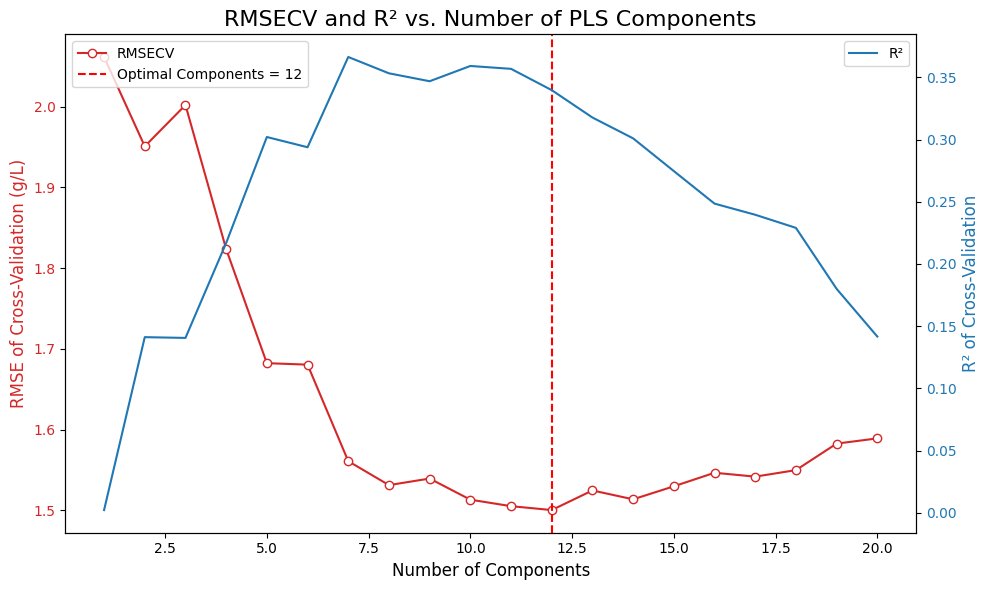

In [7]:
# We will test a range of components (latent variables)

n_components_range = np.arange(1, 21)
rmsecv_scores = []
r2cv_scores = []

# Use GroupKFold to ensure spectra from the same sample are not split across folds
# This gives a more realistic performance estimate. We use fold_idx as the group.
cv_splitter = GroupKFold(n_splits=5) # 5 groups for 5 folds

for n_comp in n_components_range:
    pls = PLSRegression(n_components=n_comp)
    # Predict using cross-validation
    y_pred_cv = cross_val_predict(pls, X_processed, Y, cv=cv_splitter, groups=groups)
    rmsecv = root_mean_squared_error(Y, y_pred_cv)
    r2cv = r2_score(Y, y_pred_cv)
    rmsecv_scores.append(rmsecv)
    r2cv_scores.append(r2cv)
    print(f"RMSECV with {n_comp} components: {rmsecv:.4f}")
    print(f"R2CV with {n_comp} components: {r2cv:.4f}")

# Find the optimal number of components (the one with the minimum RMSECV)
optimal_n_components = n_components_range[np.argmin(rmsecv_scores)]
print(f"Optimal number of PLS components found: {optimal_n_components}")

# --- Plot RMSECV vs. Number of Components, and R2 vs. Number of Components ---
fig, ax1 = plt.subplots(figsize=(10, 6))
color_rmse = 'tab:red'
color_r2 = 'tab:blue'
ax1.set_xlabel('Number of Components', fontsize=12)
ax1.set_ylabel('RMSE of Cross-Validation (g/L)', color=color_rmse, fontsize=12)
ax1.plot(n_components_range, rmsecv_scores, 'o-', mfc='w', color=color_rmse, label='RMSECV')
ax1.axvline(x=optimal_n_components, color='r', linestyle='--', label=f'Optimal Components = {optimal_n_components}')
ax1.tick_params(axis='y', labelcolor=color_rmse)
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.set_ylabel('R² of Cross-Validation', color=color_r2, fontsize=12)
ax2.plot(n_components_range, r2cv_scores, '-', color=color_r2, label='R²')
ax2.tick_params(axis='y', labelcolor=color_r2)
ax2.legend(loc='upper right')
plt.title('RMSECV and R² vs. Number of PLS Components', fontsize=16)
fig.tight_layout()
plt.show()

Final Cross-Validated Model Performance (Overall):
R²: 0.3398
RMSE: 1.5003 g/L
Glucose:
  R²: 0.3915
  RMSE: 3.3367 g/L
Na_acetate:
  R²: -0.1697
  RMSE: 0.5485 g/L
Mg_SO4:
  R²: 0.7974
  RMSE: 0.6159 g/L


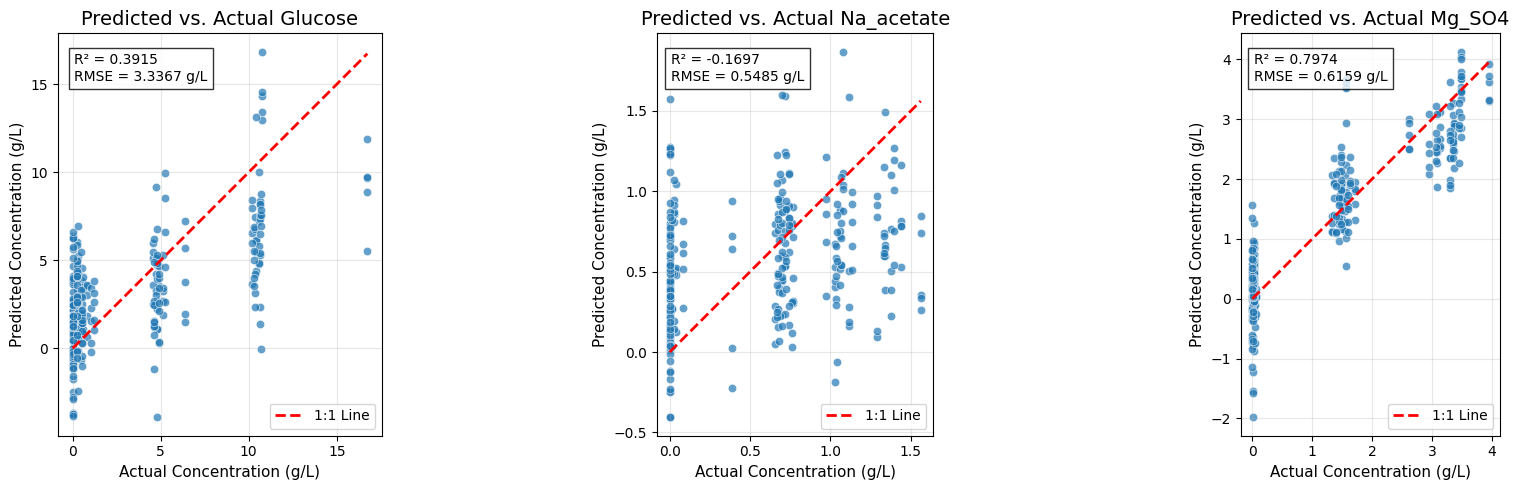

In [8]:
# =============================================================================
# Final Model Training and Evaluation
# =============================================================================

# Create the final PLS model with the optimal number of components
final_pls_model = PLSRegression(n_components=optimal_n_components)

# Get cross-validated predictions for the final model
y_pred_final = cross_val_predict(final_pls_model, X_processed, Y, cv=cv_splitter, groups=groups)

# Calculate final performance metrics (overall)
final_rmse = root_mean_squared_error(Y, y_pred_final)
final_r2 = r2_score(Y, y_pred_final)

print(f"Final Cross-Validated Model Performance (Overall):")
print(f"R²: {final_r2:.4f}")
print(f"RMSE: {final_rmse:.4f} g/L")

# Calculate individual metrics for each target
target_names = ["Glucose", "Na_acetate", "Mg_SO4"]
target_metrics = []

for i, target_name in enumerate(target_names):
    Y_target = Y[:, i]
    y_pred_target = y_pred_final[:, i]
    r2_target = r2_score(Y_target, y_pred_target)
    rmse_target = root_mean_squared_error(Y_target, y_pred_target)
    target_metrics.append((r2_target, rmse_target))
    print(f"{target_name}:")
    print(f"  R²: {r2_target:.4f}")
    print(f"  RMSE: {rmse_target:.4f} g/L")

# --- Predicted vs. Actual Plots for All Targets ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (target_name, ax) in enumerate(zip(target_names, axes)):
    Y_target = Y[:, i]
    y_pred_target = y_pred_final[:, i]
    r2_target, rmse_target = target_metrics[i]
    
    sns.scatterplot(x=Y_target, y=y_pred_target, alpha=0.7, ax=ax)
    ax.plot([Y_target.min(), Y_target.max()], [Y_target.min(), Y_target.max()], 
            'r--', lw=2, label='1:1 Line')
    ax.set_title(f'Predicted vs. Actual {target_name}', fontsize=14)
    ax.set_xlabel('Actual Concentration (g/L)', fontsize=11)
    ax.set_ylabel('Predicted Concentration (g/L)', fontsize=11)
    ax.text(0.05, 0.95, f'R² = {r2_target:.4f}\nRMSE = {rmse_target:.4f} g/L', 
            transform=ax.transAxes, fontsize=10, 
            bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


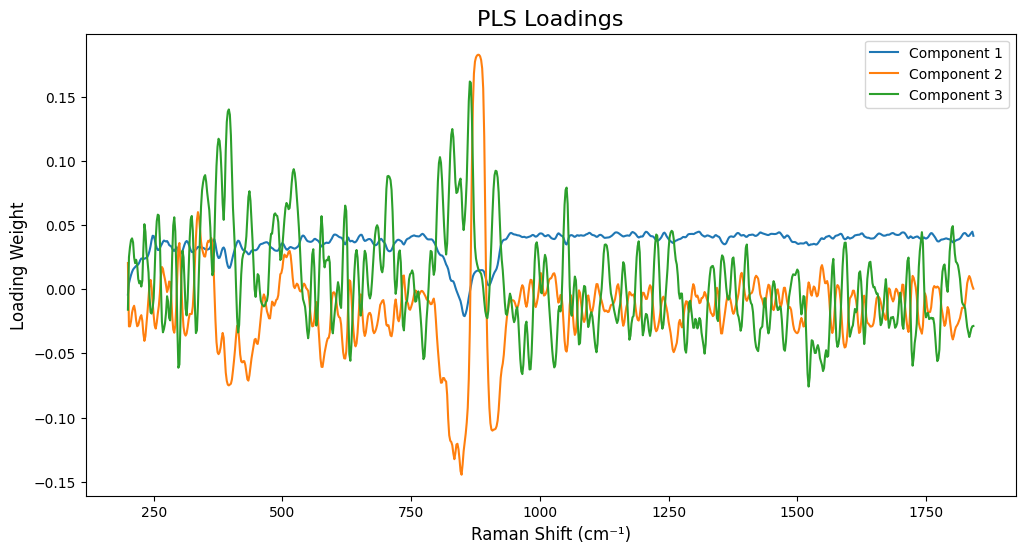

In [9]:
# =============================================================================
# Model Interpretation - Inspecting PLS Loadings
# =============================================================================

# To interpret the model, we fit it on all data and inspect the loadings.
# The loadings show which variables (wavenumbers) are important for each component.
final_pls_model.fit(X_processed, Y)
loadings = final_pls_model.x_loadings_

# --- Plot Loadings for the first few components ---
plt.figure(figsize=(12, 6))
# Ensure wavenumbers and loadings have matching dimensions
wavenumbers_plot = wavenumbers
if hasattr(wavenumbers, 'values'):
    wavenumbers_plot = wavenumbers.values
if len(wavenumbers_plot) != loadings.shape[0]:
    # Try to slice wavenumbers to match loadings shape
    wavenumbers_plot = wavenumbers_plot[:loadings.shape[0]]
for i in range(min(3, optimal_n_components)): # Plot up to the first 3 components
    plt.plot(wavenumbers_plot, loadings[:, i], label=f'Component {i+1}')

plt.title('PLS Loadings', fontsize=16)
plt.xlabel('Raman Shift (cm⁻¹)', fontsize=12)
plt.ylabel('Loading Weight', fontsize=12)
plt.legend()
plt.show()



Training PLS model for glucose
   1 components: RMSECV=4.3714, R²CV=-0.0445
   2 components: RMSECV=4.6011, R²CV=-0.1571
   3 components: RMSECV=3.8873, R²CV=0.1740
   4 components: RMSECV=3.6280, R²CV=0.2806
   5 components: RMSECV=3.3775, R²CV=0.3765
   6 components: RMSECV=3.3941, R²CV=0.3703
   7 components: RMSECV=3.3577, R²CV=0.3838
   8 components: RMSECV=3.3525, R²CV=0.3857
   9 components: RMSECV=3.4223, R²CV=0.3598
  10 components: RMSECV=3.4784, R²CV=0.3387
  11 components: RMSECV=3.5761, R²CV=0.3010
  12 components: RMSECV=3.6763, R²CV=0.2613
  13 components: RMSECV=3.7758, R²CV=0.2207
  14 components: RMSECV=3.8433, R²CV=0.1926
  15 components: RMSECV=3.8770, R²CV=0.1784
  16 components: RMSECV=3.9075, R²CV=0.1655
  17 components: RMSECV=3.9259, R²CV=0.1576
  18 components: RMSECV=3.9506, R²CV=0.1469
  19 components: RMSECV=3.9550, R²CV=0.1450
  20 components: RMSECV=3.9898, R²CV=0.1299

  Optimal components for glucose: 8
  Final R²: 0.3857, RMSE: 3.3525 g/L

Training PL

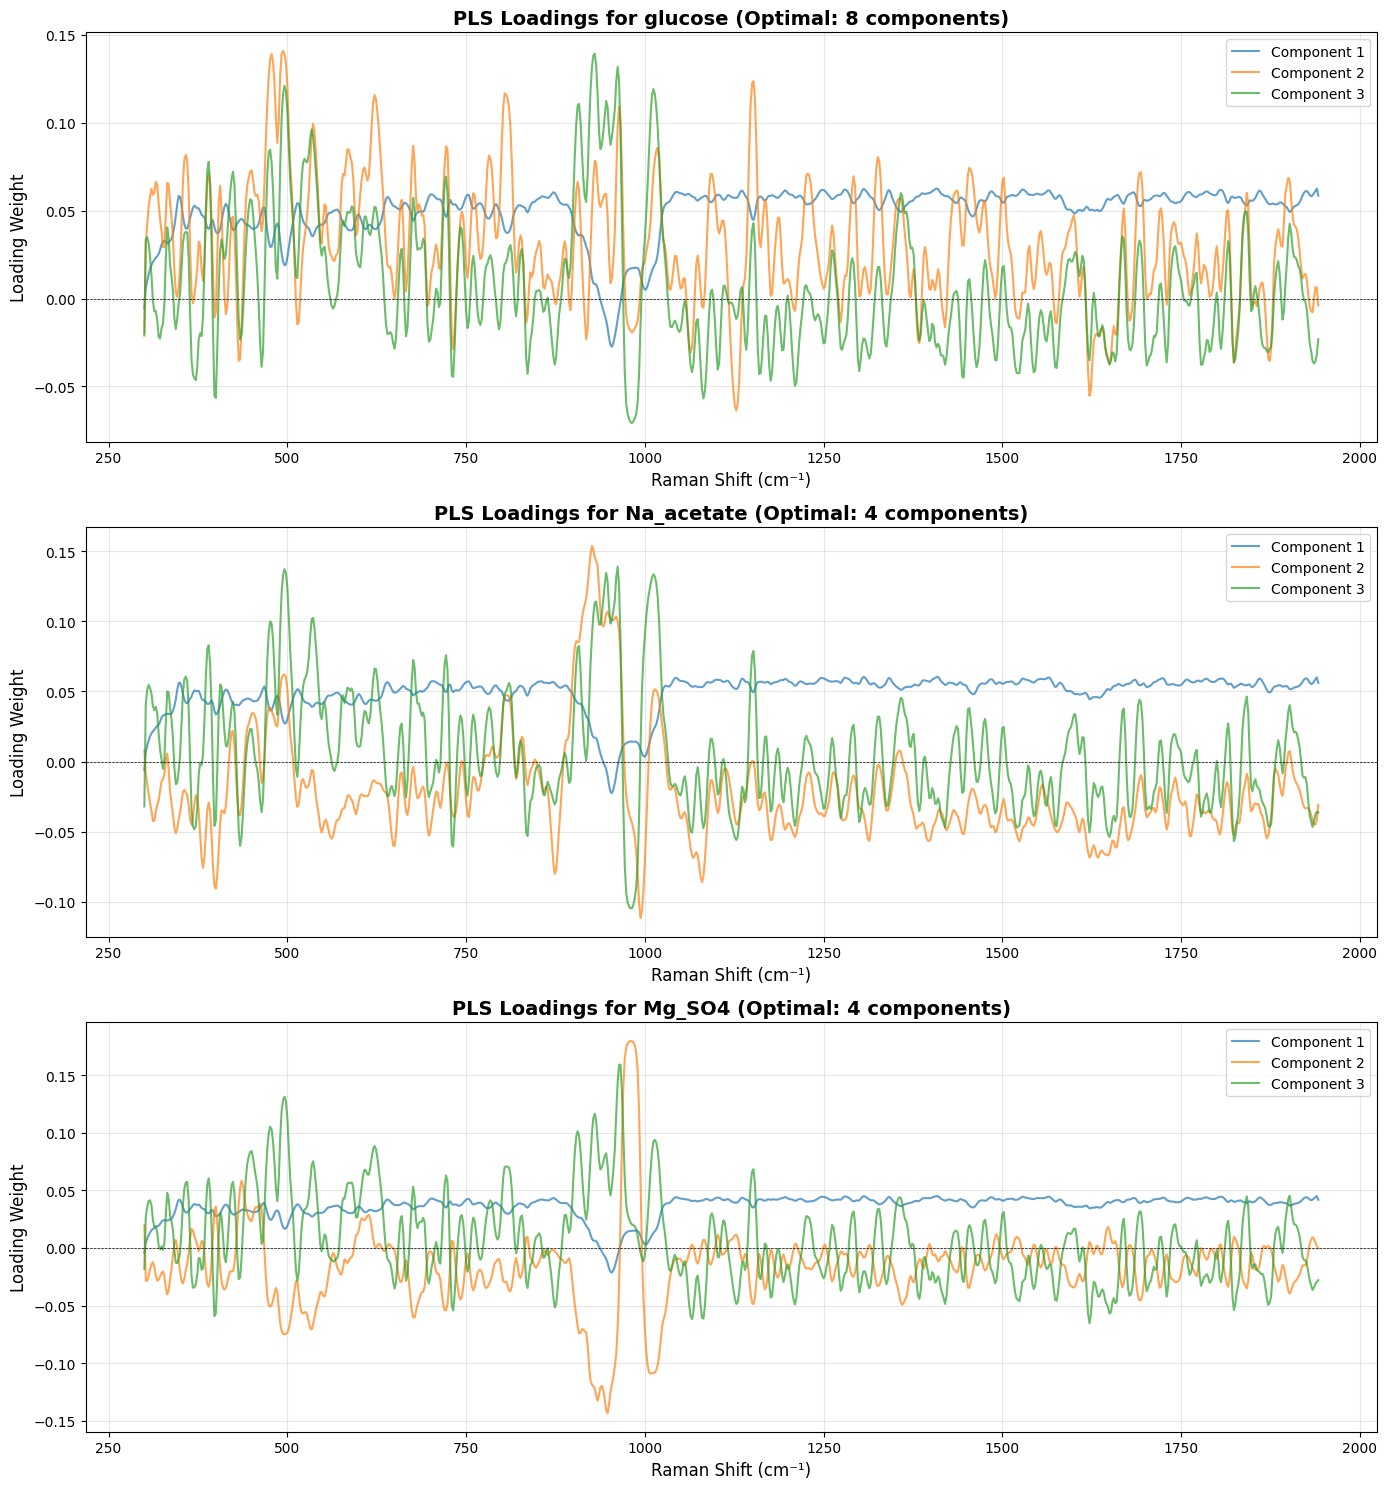


Performance Comparison: Single Multi-Output Model vs. Separate Models
Target          Single Model R²    Separate Model R²  R² Improvement  Single RMSE     Separate RMSE   RMSE Improvement
--------------------------------------------------------------------------------
glucose                    0.3915            0.3857        -0.0058         3.3367 g/L         3.3525 g/L        -0.0159 g/L
Na_acetate                -0.1697            0.0156        +0.1853         0.5485 g/L         0.5032 g/L        +0.0453 g/L
Mg_SO4                     0.7974            0.8131        +0.0157         0.6159 g/L         0.5916 g/L        +0.0243 g/L


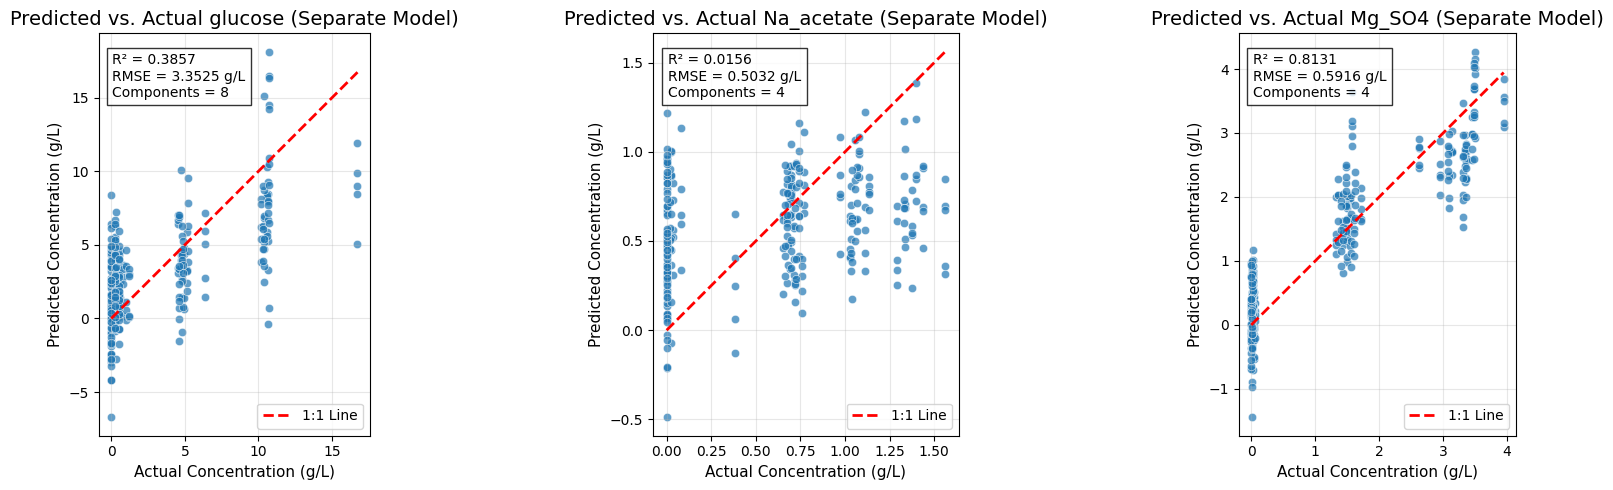

In [10]:
# =============================================================================
# Separate PLS Models Per Target
# =============================================================================
# 
# Training one PLS model per target allows:
# - Better interpretability: each target has its own loadings showing which 
#   spectral regions are important for that specific compound
# - Independent optimization: each target can have its own optimal number of 
#   components
# - Potentially better performance: models can focus on the specific spectral 
#   regions relevant to each compound

target_names = ["glucose", "Na_acetate", "Mg_SO4"]
target_models = {}
target_optimal_components = {}
target_metrics_separate = {}
target_predictions_separate = {}

# Store single model metrics for comparison (from cell 11)
target_metrics_single = {}
for i, target_name in enumerate(target_names):
    Y_target = Y[:, i]
    y_pred_target = y_pred_final[:, i]
    r2_target = r2_score(Y_target, y_pred_target)
    rmse_target = root_mean_squared_error(Y_target, y_pred_target)
    target_metrics_single[target_name] = (r2_target, rmse_target)

# Train separate PLS model for each target
for target_idx, target_name in enumerate(target_names):
    print(f"\n{'='*60}")
    print(f"Training PLS model for {target_name}")
    print(f"{'='*60}")
    
    # Extract single target
    Y_target = Y[:, target_idx].reshape(-1, 1)  # Reshape to (n_samples, 1)
    
    # Find optimal number of components for this target
    n_components_range = np.arange(1, 21)
    rmsecv_scores = []
    r2cv_scores = []
    
    for n_comp in n_components_range:
        pls = PLSRegression(n_components=n_comp)
        y_pred_cv = cross_val_predict(pls, X_processed, Y_target, cv=cv_splitter, groups=groups)
        rmsecv = root_mean_squared_error(Y_target, y_pred_cv)
        r2cv = r2_score(Y_target, y_pred_cv)
        rmsecv_scores.append(rmsecv)
        r2cv_scores.append(r2cv)
        print(f"  {n_comp:2d} components: RMSECV={rmsecv:.4f}, R²CV={r2cv:.4f}")
    
    # Find optimal number of components
    optimal_n_components = n_components_range[np.argmin(rmsecv_scores)]
    target_optimal_components[target_name] = optimal_n_components
    print(f"\n  Optimal components for {target_name}: {optimal_n_components}")
    
    # Train final model and get cross-validated predictions
    final_pls = PLSRegression(n_components=optimal_n_components)
    y_pred_final_separate = cross_val_predict(final_pls, X_processed, Y_target, cv=cv_splitter, groups=groups)
    
    # Calculate metrics
    r2_final = r2_score(Y_target, y_pred_final_separate)
    rmse_final = root_mean_squared_error(Y_target, y_pred_final_separate)
    target_metrics_separate[target_name] = (r2_final, rmse_final)
    target_models[target_name] = final_pls
    target_predictions_separate[target_name] = y_pred_final_separate
    
    print(f"  Final R²: {r2_final:.4f}, RMSE: {rmse_final:.4f} g/L")

# =============================================================================
# Plot Loadings for Each Target (Much More Interpretable!)
# =============================================================================

fig, axes = plt.subplots(len(target_names), 1, figsize=(14, 5*len(target_names)))

# Handle case where we have only one target (axes would be 1D, not 2D)
if len(target_names) == 1:
    axes = [axes]

for idx, target_name in enumerate(target_names):
    model = target_models[target_name]
    # Fit the model on all data to get loadings
    model.fit(X_processed, Y[:, idx].reshape(-1, 1))
    loadings = model.x_loadings_
    
    # Use wavenumbers from processed spectra to match loadings dimensions
    wavenumbers_processed = processed_spectra.spectral_axis
    if hasattr(wavenumbers_processed, 'values'):
        wavenumbers_processed = wavenumbers_processed.values
    
    ax = axes[idx]
    n_comp_to_plot = min(3, target_optimal_components[target_name])
    for comp_idx in range(n_comp_to_plot):
        ax.plot(wavenumbers_processed, loadings[:, comp_idx], 
                label=f'Component {comp_idx+1}', alpha=0.7, linewidth=1.5)
    
    ax.set_title(f'PLS Loadings for {target_name} (Optimal: {target_optimal_components[target_name]} components)', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Raman Shift (cm⁻¹)', fontsize=12)
    ax.set_ylabel('Loading Weight', fontsize=12)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# =============================================================================
# Performance Comparison: Single vs. Separate Models
# =============================================================================

print("\n" + "="*80)
print("Performance Comparison: Single Multi-Output Model vs. Separate Models")
print("="*80)
print(f"{'Target':<15} {'Single Model R²':<18} {'Separate Model R²':<18} {'R² Improvement':<15} {'Single RMSE':<15} {'Separate RMSE':<15} {'RMSE Improvement':<15}")
print("-"*80)

for target_name in target_names:
    single_r2, single_rmse = target_metrics_single[target_name]
    separate_r2, separate_rmse = target_metrics_separate[target_name]
    r2_improvement = separate_r2 - single_r2
    rmse_improvement = single_rmse - separate_rmse  # Positive = better (lower RMSE)
    
    print(f"{target_name:<15} {single_r2:>17.4f} {separate_r2:>17.4f} {r2_improvement:>+14.4f} {single_rmse:>14.4f} g/L {separate_rmse:>14.4f} g/L {rmse_improvement:>+14.4f} g/L")

print("="*80)

# =============================================================================
# Predicted vs. Actual Plots for Separate Models
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (target_name, ax) in enumerate(zip(target_names, axes)):
    Y_target = Y[:, idx]
    y_pred_target = target_predictions_separate[target_name].flatten()
    r2_target, rmse_target = target_metrics_separate[target_name]
    
    sns.scatterplot(x=Y_target, y=y_pred_target, alpha=0.7, ax=ax)
    ax.plot([Y_target.min(), Y_target.max()], [Y_target.min(), Y_target.max()], 
            'r--', lw=2, label='1:1 Line')
    ax.set_title(f'Predicted vs. Actual {target_name} (Separate Model)', fontsize=14)
    ax.set_xlabel('Actual Concentration (g/L)', fontsize=11)
    ax.set_ylabel('Predicted Concentration (g/L)', fontsize=11)
    ax.text(0.05, 0.95, f'R² = {r2_target:.4f}\nRMSE = {rmse_target:.4f} g/L\nComponents = {target_optimal_components[target_name]}', 
            transform=ax.transAxes, fontsize=10, 
            bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

## Conclusion

This notebook demonstrates the development of **Partial Least Squares (PLS) regression models** for predicting concentrations of glucose, Na_acetate, and Mg_SO4 from Raman spectra. The following summarizes key findings and decisions:

### Preprocessing Pipeline

**Spectral Preprocessing Steps:**

1. **Cropping** to the fingerprint region (300-1942 cm⁻¹) to focus on the most informative spectral region
2. **Cosmic ray removal** using the Whitaker-Hayes algorithm to eliminate spurious high-intensity spikes
3. **Savitzky-Golay smoothing** (window length=9, polynomial order=3) to reduce high-frequency noise
4. **Baseline correction** using Adaptive Smoothing Parameter Least Squares (ASPLS) to remove fluorescence background

**Normalization:**

- **MinMax normalization** was applied despite its limitations for regression tasks. This choice was necessary to handle high intensity variations (values reaching ~350 arbitrary units), as internal standard normalization was not feasible in this context due to the lack of a suitable reference peak.

### Modeling Approach

Two modeling strategies were compared:

**1. Single Multi-Output PLS Model**

- One PLS model predicting all three targets simultaneously
- Optimal components: 12
- Overall R²: 0.34, RMSE: 1.50 g/L
- Individual performance varied significantly across targets

**2. Separate PLS Models Per Target**

- Independent PLS models for each compound with individually optimized component counts
- **Glucose**: 8 components, R²: 0.39, RMSE: 3.35 g/L
- **Na_acetate**: 4 components, R²: 0.02, RMSE: 0.50 g/L  
- **Mg_SO4**: 4 components, R²: 0.81, RMSE: 0.59 g/L

### Key Insights

1. **Separate models provide superior interpretability**: Each target has its own loadings that clearly show which spectral regions are important for that specific compound, making the models more interpretable and chemically meaningful.

2. **Independent optimization is beneficial**: Different targets require different numbers of components (8 for glucose vs. 4 for Na_acetate and Mg_SO4), demonstrating that separate models allow for better hyperparameter tuning tailored to each compound's spectral characteristics.

3. **Performance varies significantly by compound**: 

   - **Mg_SO4** shows **excellent** predictive performance (R² = 0.81), indicating strong, distinct spectral signatures that are easily captured by the model.
   - **Glucose** shows **moderate** performance (R² = 0.39), suggesting some predictive capability but with room for improvement through feature engineering or alternative preprocessing.
   - **Na_acetate** shows **poor** performance (R² ≈ 0.02), indicating weak or overlapping spectral features that may require additional preprocessing, feature selection, or alternative modeling approaches.

4. **Model selection recommendation**: For production use, **separate PLS models per target are recommended** due to their:

   - Improved interpretability through target-specific loadings
   - Independent optimization capabilities for each compound
   - Ability to focus on compound-specific spectral regions